In [1]:
import os
import tensorflow as tf
import helper
import warnings
import numpy as np
import time
import project_tests as tests
from distutils.version import LooseVersion

In [2]:
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'),'Please use tensorFlow version 1.0 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0


/Users/honghuxu/anaconda3/envs/carnd-advdl-odlab/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


In [3]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess,[vgg_tag],vgg_path)
    image_input = tf.get_default_graph().get_tensor_by_name(vgg_input_tensor_name)
    keep_prob = tf.get_default_graph().get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out = tf.get_default_graph().get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out = tf.get_default_graph().get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out = tf.get_default_graph().get_tensor_by_name(vgg_layer7_out_tensor_name)
    
    return image_input, keep_prob, layer3_out, layer4_out, layer7_out

tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [4]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    # 1x1 convolution vgg layer 7
    conv_7out = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # upsample
    output_4in = tf.layers.conv2d_transpose(conv_7out, num_classes, 4, strides= (2, 2), padding= 'same', 
                                             kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # 1x1 convolution vgg layer 4
    conv_4in = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # skip connection
    layer_4out = tf.add(output_4in, conv_4in)
    # upsample
    output_3in = tf.layers.conv2d_transpose(layer_4out, num_classes, 4,  strides= (2, 2), padding= 'same', 
                                             kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # 1x1 convolution vgg layer 3
    conv_3in = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # skip connection
    layer_3out = tf.add(output_3in, conv_3in)
    # upsample
    nn_last_layer = tf.layers.conv2d_transpose(layer_3out, num_classes, 16,  strides= (8, 8), padding= 'same', 
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                               kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    return nn_last_layer

tests.test_layers(layers)

Tests Passed


In [5]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    # logits is a 2D tensor, to indicates pixel and class
    logits = tf.reshape(nn_last_layer,(-1,num_classes))
    labels = tf.reshape(correct_label,(-1,num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels= labels))
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
    
    return logits, optimizer.minimize(cross_entropy_loss), cross_entropy_loss
    
tests.test_optimize(optimize)


Tests Passed


In [6]:
log = {'loss':[]}

def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    
    
    for i in range(epochs):
        for image, label in get_batches_fn(batch_size):
            _, loss = sess.run([train_op,cross_entropy_loss],feed_dict={input_image:image,correct_label:label,
                                        keep_prob:0.75,learning_rate: 0.0001})
            
        print("EPOCH {} ...".format(i + 1))
        print("loss = {:.5f}".format(loss))
        print()
        time.time()

        
        # record a log inside the loop for further accuracy evaluation
        log['loss'].append(loss)

                  
tests.test_train_nn(train_nn)

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'


In [7]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    
    epochs = 15
    batch_size = 8

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function
        label = tf.placeholder(dtype = tf.float32, shape = (None, None, None, num_classes))
        learning_rate = tf.placeholder(dtype=tf.float32)
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess,vgg_path)
        layers_output = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
        logits, train_op, cross_entropy_loss = optimize(layers_output, label, learning_rate, num_classes)

        # TODO: Train NN using the train_nn function
        sess.run(tf.global_variables_initializer())
        train_nn(sess,epochs,batch_size,get_batches_fn,train_op,cross_entropy_loss,input_image,label,keep_prob,learning_rate)

        # TODO: Save inference data using helper.save_inference_samples
        saver = tf.train.Saver()
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video
        

In [8]:
if __name__ == '__main__':
    run()

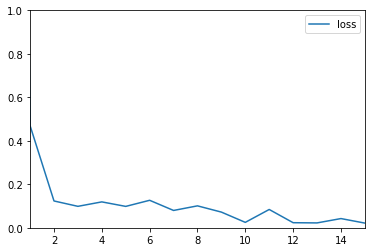

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log['loss'], label='loss')
plt.ylim(0.0,1.0)
plt.xlim(1.0,15.0)
plt.legend()

Training Log:
EPOCH 1 ...
loss = 0.46971

EPOCH 2 ...
loss = 0.12342

EPOCH 3 ...
loss = 0.09872

EPOCH 4 ...
loss = 0.11918

EPOCH 5 ...
loss = 0.09845

EPOCH 6 ...
loss = 0.12651

EPOCH 7 ...
loss = 0.07980

EPOCH 8 ...
loss = 0.10093

EPOCH 9 ...
loss = 0.07220

EPOCH 10 ...
loss = 0.02500

EPOCH 11 ...
loss = 0.08426

EPOCH 12 ...
loss = 0.02344

EPOCH 13 ...
loss = 0.02246

EPOCH 14 ...
loss = 0.04246

EPOCH 15 ...
loss = 0.02161